## Names and Religiosity

### Introduction

The core idea behind our analysis is examining the relationship between the religiosity of names and various social trends. In order to validate that this is a reasonable line of inquiry when it comes to second or third order associations  (like religiosity of names -> religiosity of people -> social conservatism of people) we should first validate that first order associations hold  (like religiosity of names -> religiosity of people). One trend we might want to examine initially is trends in the proportion of names that belong to different religious faiths (male and female)

### General Trends

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import urllib2
from bs4 import BeautifulSoup

%matplotlib inline
matplotlib.style.use('ggplot')

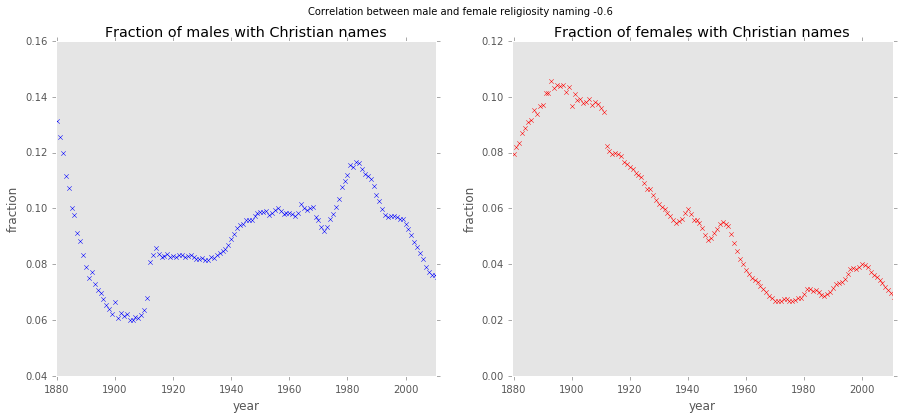

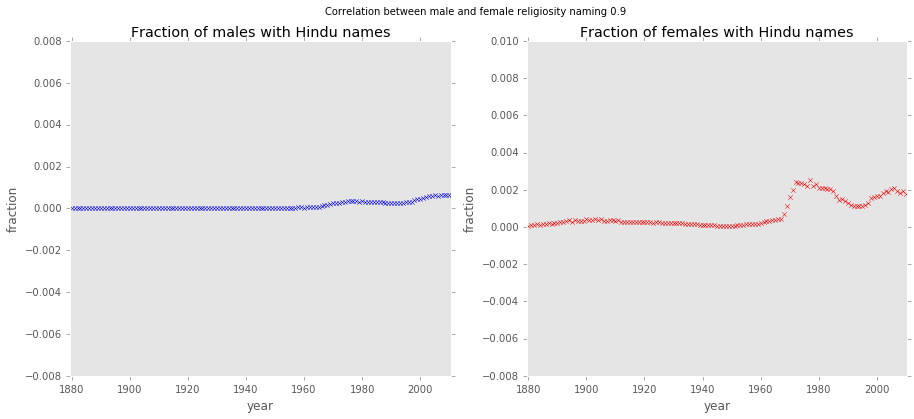

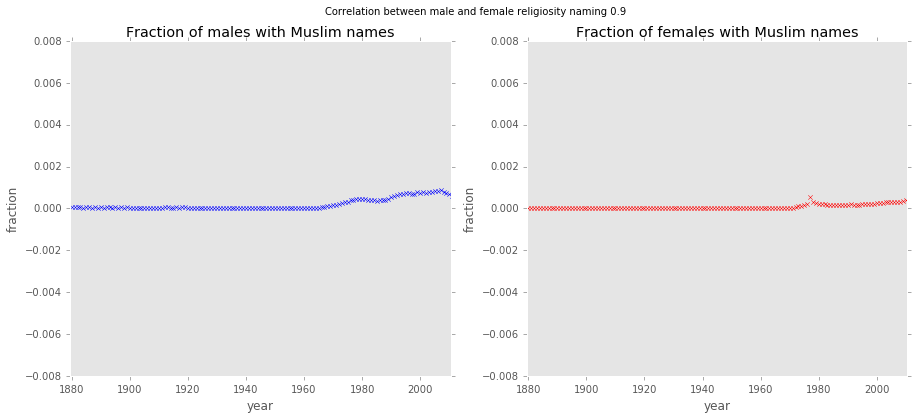

In [2]:
df = pd.read_csv('data/NationalNames.csv')

def plot_name_trend(male_name_set, female_name_set,rel_str):
    male_fracs = []
    female_fracs = []

    years = xrange(df['Year'].min(), df['Year'].max() + 1, 1)

    for year in years:
        df_year = df.loc[(df['Year'] == year), :]
        pop_count = 1. * df_year['Count'].sum()

        male_count = df_year.loc[df_year['Name'].apply(lambda x : x in male_name_set)]['Count'].sum()
        female_count = df_year.loc[df_year['Name'].apply(lambda x : x in female_name_set)]['Count'].sum()

        male_frac, female_frac = male_count / pop_count, female_count / pop_count

        male_fracs.append(male_frac)
        female_fracs.append(female_frac)

    male_fracs = np.array(male_fracs)
    female_fracs = np.array(female_fracs)

    fig = plt.figure(figsize=(15, 6))
    
    fig.suptitle("Correlation between male and female religiosity naming %.1f" % np.corrcoef(male_fracs, female_fracs)[0][1])

    male_ax = fig.add_subplot(1, 2, 1)
    female_ax = fig.add_subplot(1, 2, 2)

    male_ax.scatter(years, male_fracs, color='blue', marker='x')
    female_ax.scatter(years, female_fracs, color='red', marker='x')

    male_ax.set_xlim(1879.5, 2010.5)
    female_ax.set_xlim(1879.5, 2010.5)

    male_ax.set_title('Fraction of males with ' + rel_str + ' names')
    female_ax.set_title('Fraction of females with ' + rel_str + ' names')

    male_ax.set_xlabel('year')
    male_ax.set_ylabel('fraction')

    female_ax.set_xlabel('year')
    female_ax.set_ylabel('fraction')
    
    male_ax.grid(False)
    female_ax.grid(False)
    
rel_data = pd.read_csv('data/Names_and_Religion.csv')

for key,grp in rel_data.groupby('Religion'):
    plot_name_trend(grp.groupby('Gender').get_group('M').values,grp.groupby('Gender').get_group('F').values,key)
print

Below we show the trend in religious naming for all faiths (by gender). As we can see, over the all-time scale there has been a sharp dropoff in both male and female religious names. Interestingly the trends in religious naming appear to be relatively negatively correlated between males and females in terms of Christian naming but are highly positively correlated for Muslims and Hindus (although this is largely due to the fact that throughout American history there have been very few Muslim and Hindu people in America)c.

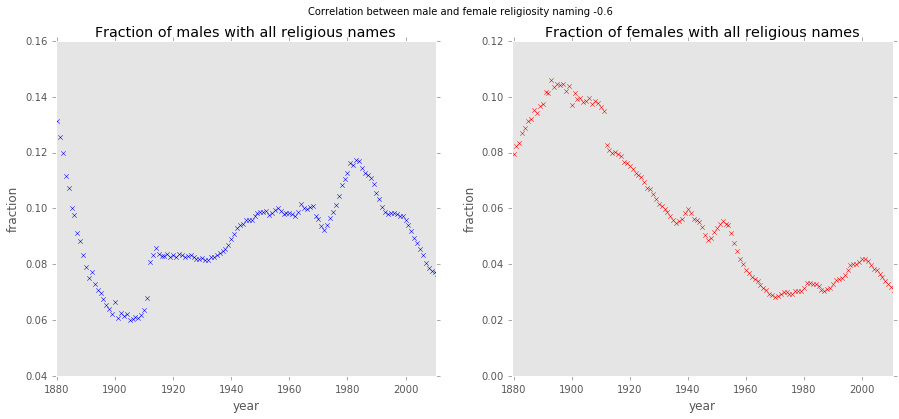

In [3]:
 plot_name_trend(rel_data.groupby('Gender').get_group('M').values,rel_data.groupby('Gender').get_group('F').values,"all religious")

Since religions other than Christianity are very sparse in America it appears to be sensible to constrain our analysis to Christian names. Specifically, to gauge trends in devoutness in religious naming we analyze trends in the proportion of biblical names.

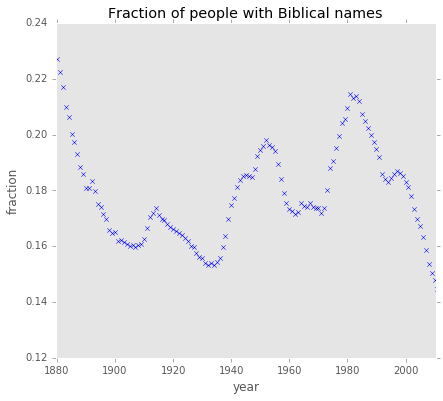

In [4]:
# not making a function because this is super specific
link_orig = "https://en.wikipedia.org/wiki/List_of_biblical_names"
holder = []
page_orig = urllib2.urlopen(link_orig)
soup_orig = BeautifulSoup(page_orig)
for curr_link in soup_orig.body.table.findAll('a'):
    tmp_link =  curr_link.get('href')
    use_link= "https://en.wikipedia.org"+tmp_link
    page = urllib2.urlopen(use_link)
    soup = BeautifulSoup(page)
    for li in soup.html.body.ul.findAll('li'):
        tmp_str = li.text
        tmp_broken = tmp_str.split(',')
        holder.append(tmp_broken[0])


biblical = pd.DataFrame(holder, columns = ['Names'])
biblical = biblical.loc[:, 'Names'].apply(lambda x : x.encode('utf-8'))
biblical.to_csv('data/biblical.txt', index=False)

def plot_name_trend_one_set(male_name_set,rel_str):
    male_fracs = []

    years = xrange(df['Year'].min(), df['Year'].max() + 1, 1)

    for year in years:
        df_year = df.loc[(df['Year'] == year), :]
        pop_count = 1. * df_year['Count'].sum()

        male_count = df_year.loc[df_year['Name'].apply(lambda x : x in male_name_set)]['Count'].sum()  

        male_frac= male_count / pop_count

        male_fracs.append(male_frac)

    male_fracs = np.array(male_fracs)

    fig = plt.figure(figsize=(15, 6))

    male_ax = fig.add_subplot(1, 2, 1)

    male_ax.scatter(years, male_fracs, color='blue', marker='x')

    male_ax.set_xlim(1879.5, 2010.5)

    male_ax.set_title('Fraction of people with ' + rel_str + ' names')

    male_ax.set_xlabel('year')
    male_ax.set_ylabel('fraction')
    
    male_ax.grid(False)

plot_name_trend_one_set(biblical.values,'Biblical')

### Biblical Naming and Christianity

Using data from the General Social Survey we can construct a model that predicts the percentage of people that are affiliated with a Christian set in an area from the percentage of people wit biblical names. A linear regression model yields an $R^2$ of $.74$. This is a fairly strong relationship, and validates our first order hypothesis that religiosity in naming is associated with religiosity in general.

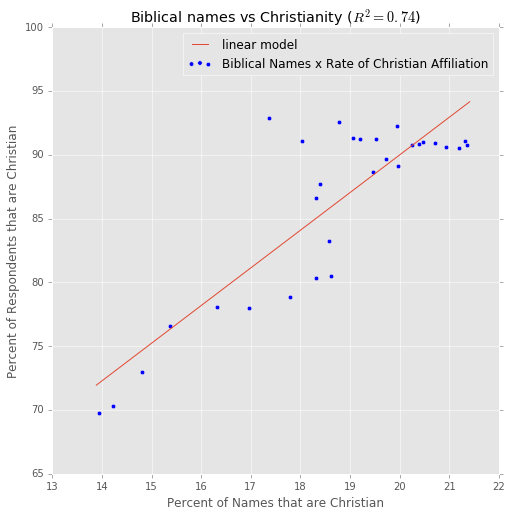

In [5]:
from sklearn.linear_model import LinearRegression

adriana_df = pd.read_csv('data/GSS_condensed.csv')
biblical_df = pd.read_csv('data/biblical.txt', header=None)

national_df = pd.read_csv('data/NationalNames.csv')

biblical_names = set(biblical_df.loc[:, 0])

adriana_df = adriana_df.loc[:, ['year', 'relig']]

years = adriana_df['year'].drop_duplicates().values

christian = adriana_df.loc[adriana_df['relig'].apply(lambda x : x in (1,2,3))].groupby(['year']).count()['relig'].values
base = adriana_df.groupby(['year']).count()['relig'].values



data = np.array([years, 1.0 * christian / base]).T

df = national_df

fracs = []

for year in years:
    df_year = df.loc[(df['Year'] == year), :]
    pop_count = 1. * df_year['Count'].sum()

    bib_count = df_year.loc[df_year['Name'].apply(lambda x : x in biblical_names)]['Count'].sum()

    frac = bib_count / pop_count
    fracs.append(frac)

fracs = 100. * np.array(fracs) 

religious_data = 100. * christian / base

model = LinearRegression()
model.fit(fracs.reshape(-1, 1), religious_data)
model.score

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.scatter(fracs, religious_data, label='Biblical Names x Rate of Christian Affiliation')

ax.set_xlabel('Percent of Names that are Christian')
ax.set_ylabel('Percent of Respondents that are Christian')

ax.set_title('Biblical names vs Christianity ($R^2 = %.2f$)' % model.score(fracs.reshape(-1, 1), religious_data))

xs = np.linspace(fracs.min() - 0.05, fracs.max() + 0.05, 1000)
ys = model.predict(xs.reshape(-1, 1))

ax.plot(xs, ys, label='linear model')

#ax.set_xlim(name_data.min() - 0.06, name_data.max() + 0.06)
ax.legend(loc='best')



### Biblical Naming and Church Attendance

Under the hypothesis that biblical naming is associated with levels of Christianity we also hypothesized there may be a direct relationship to levels of Christian religiosity as well as reflected by rates of church attendance. However, we found no signficant relationship.

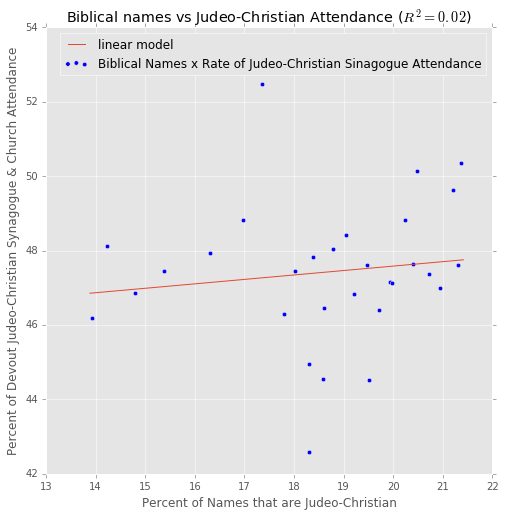

In [6]:
GSS_df = pd.read_csv('data/GSS_condensed.csv')

biblical_names = set(biblical_df.loc[:, 0])

GSS_attend_df = GSS_df.loc[:, ['year', 'relig', 'attend']]

#Drop if relig is not judeo-christian
GSS_attend_df_JC = GSS_attend_df.ix[GSS_attend_df['relig'] < 4]

years = GSS_attend_df_JC['year'].drop_duplicates().values

#Take individuals that go to church at least 2-3 times a month
devout = GSS_attend_df_JC.loc[GSS_attend_df_JC['attend'].apply(lambda x : x in (5,6,7,8))].groupby(['year']).count()['attend'].values
base = GSS_attend_df_JC.groupby(['year']).count()['attend'].values
data_attend = np.array([years, 1.0 * devout / base]).T

df = national_df

#counting biblical names
fracs = []

for year in years:
    df_year = df.loc[(df['Year'] == year), :]
    pop_count = 1. * df_year['Count'].sum()

    bib_count = df_year.loc[df_year['Name'].apply(lambda x : x in biblical_names)]['Count'].sum()

    frac = bib_count / pop_count
    fracs.append(frac)

fracs = 100. * np.array(fracs)
religious_data_devout = 100. * devout/ base

model = LinearRegression()
model.fit(fracs.reshape(-1, 1), religious_data_devout)
model.score


fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.scatter(fracs, religious_data_devout, label='Biblical Names x Rate of Judeo-Christian Sinagogue Attendance')

ax.set_xlabel('Percent of Names that are Judeo-Christian')
ax.set_ylabel('Percent of Devout Judeo-Christian Synagogue & Church Attendance')

ax.set_title('Biblical names vs Judeo-Christian Attendance ($R^2 = %.2f$)' % model.score(fracs.reshape(-1, 1), religious_data_devout))

xs = np.linspace(fracs.min() - 0.05, fracs.max() + 0.05, 1000)
ys = model.predict(xs.reshape(-1, 1))

ax.plot(xs, ys, label='linear model')

ax.legend(loc='best')